Cite:
- STFTs,MelSpec,MFCCs,Gammatonegram,CQT spectrograms:https://github.com/KinWaiCheuk/nnAudio/tree/master/Installation/nnAudio/features
- Demon,Lofar:https://github.com/pedrolisboa/poseidon/blob/master/poseidon/signal/passivesonar.py

In [1]:
from nnAudio import features
from nnAudio.librosa_functions import normalize
from scipy.io import wavfile
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def torch_to_np(spec):
    output = spec.cpu().detach().numpy()
    output.shape # (num_samples, freq_bins,time_steps)
    output_sque = np.squeeze(output)
    return output_sque

In [3]:
def _power_to_db(S):
    """
    Refer to https://librosa.github.io/librosa/_modules/librosa/core/spectrum.html#power_to_db
    for the original implmentation.
    """
    amin=1e-10,
    top_db=80.0
    ref=1.0
    
    log_spec = 10.0 * torch.log10(torch.max(S, amin))
    log_spec -= 10.0 * torch.log10(torch.max(amin, ref))
    if top_db is not None:
        if top_db < 0:
            raise ParameterError("top_db must be non-negative")

        # make the dim same as log_spec so that it can be broadcasted
        batch_wise_max = log_spec.flatten(1).max(1)[0].unsqueeze(1).unsqueeze(1)
        log_spec = torch.max(log_spec, batch_wise_max - top_db)

    return log_spec

In [4]:
def draw(spec):
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(1,2,1)
    ax.imshow(torch_to_np(spec), aspect='auto', origin='lower',cmap='jet')
    ax.set_title('Spec')
    ax = fig.add_subplot(1,2,2)
    ax.imshow(np.log10(torch_to_np(spec)**2), aspect='auto', origin='lower',cmap='jet')
    ax.set_title('log10 Spec')

In [5]:
audio_path = r'../data/DeepShip_test/Cargo/20171105a-3/3.wav/00000.wav'
#audio_path = r'../data/DeepShip_test/Tug/20171111-7/025236.wav/00000.wav'
sr, song = wavfile.read(audio_path) # Loading your audio
x = song #.mean(1) # Converting Stereo  to Mono
x = torch.tensor(x, device='cpu').float() # casting the array into a PyTorch Tensor

sampling rate = 22050. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.1152 seconds


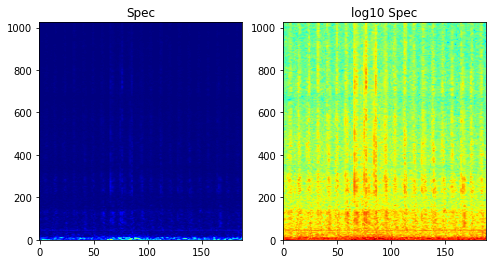

In [6]:
# a) STFTs
spec_layer = features.STFT(n_fft=2048, win_length=None, freq_bins=None, hop_length=None, window='hann', freq_scale='linear', center=True, 
                           pad_mode='reflect', iSTFT=False, fmin=50, fmax=6000, sr=22050, trainable=False, output_format='Magnitude') # Initializing the model

spec = spec_layer(x) # Feed-forward your waveform to get the spectrogram
draw(spec)

STFT kernels created, time used = 0.0919 seconds
STFT filter created, time used = 0.0030 seconds
Mel filter created, time used = 0.0030 seconds


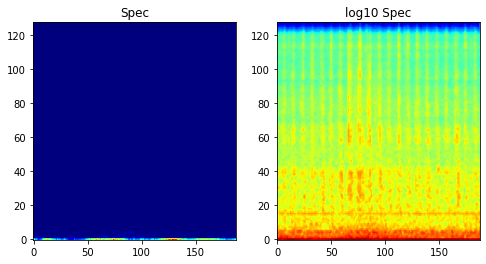

In [7]:
# b)MelSpec
spec_layer = features.MelSpectrogram(sr=sr, n_fft=2048, win_length=None, n_mels=128, hop_length=512, 
                                     window='hann', center=True, pad_mode='reflect', power=2.0, htk=False, 
                                     fmin=0.0, fmax=None, norm=1, trainable_mel=False, trainable_STFT=False, verbose=True)
melspec = spec_layer(x)
draw(melspec)

STFT kernels created, time used = 0.0866 seconds
STFT filter created, time used = 0.0030 seconds
Mel filter created, time used = 0.0030 seconds


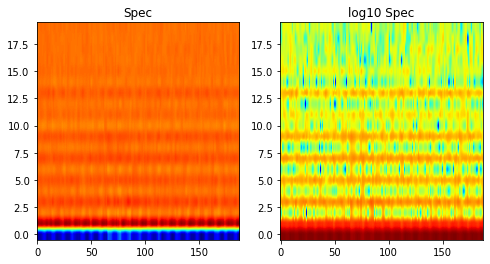

In [8]:
# c)MFCCs
spec_layer = features.mel.MFCC(sr=sr, n_mfcc=20, norm='ortho', verbose=True, ref=1.0, amin=1e-10, top_db=80.0)
MFCCs = spec_layer(x)
draw(MFCCs)

STFT filter created, time used = 0.0130 seconds
Gammatone filter created, time used = 0.0140 seconds


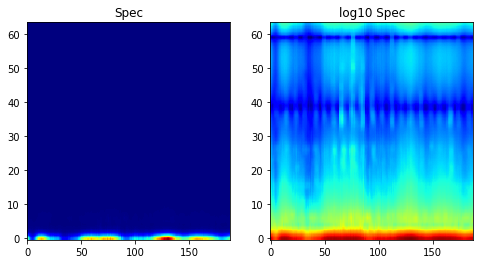

In [9]:
# d)Gammatonegram
spec_layer = features.Gammatonegram(sr=sr, n_fft=2048, n_bins=64, hop_length=512, window='hann', center=True, pad_mode='reflect', 
                                    power=2.0, htk=False, fmin=20.0, fmax=None, norm=1, 
                                    trainable_bins=False, trainable_STFT=False, verbose=True)
Gammatonegram = spec_layer(x)
draw(Gammatonegram)

Low pass filter created, time used = 0.0010 seconds
num_octave =  7
No early downsampling is required, downsample_factor =  1
Early downsampling filter created,                         time used = 0.0000 seconds
CQT kernels created, time used = 0.0040 seconds


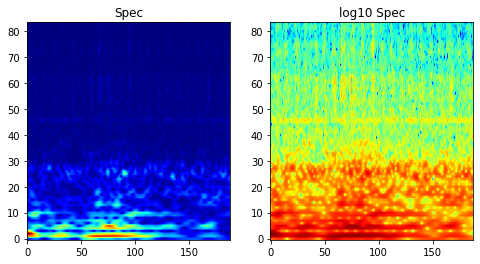

In [10]:
# e)CQT spectrograms
spec_layer = features.CQT2010v2(sr=sr, hop_length=512, fmin=32.7, fmax=None, n_bins=84, filter_scale=1, 
                                bins_per_octave=12, norm=True, basis_norm=1, window='hann', pad_mode='reflect', 
                                earlydownsample=True, trainable=False, output_format='Magnitude', verbose=True)
CQTspec = spec_layer(x)
draw(CQTspec)

In [11]:
import passivesonar

In [12]:
len(song)

96000

In [13]:
demon_power, freq, time = passivesonar.demon(song, sr, 1024)
lofar_power, freq, time = passivesonar.lofar(song, sr, 1024)

C:\Users\Administrator\AppData\Roaming\Python\Python36\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=206
  return f(*args, **kwargs)


Text(0.5, 1.0, 'Lofar')

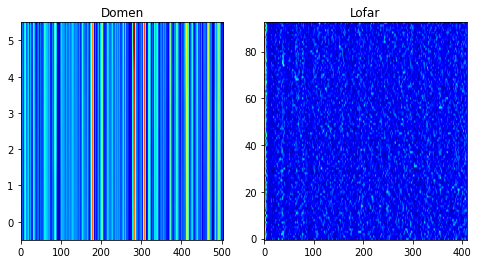

In [14]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,2,1)
ax.imshow(demon_power, aspect='auto', origin='lower',cmap='jet')
ax.set_title('Domen')
ax = fig.add_subplot(1,2,2)
ax.imshow(lofar_power, aspect='auto', origin='lower',cmap='jet')
ax.set_title('Lofar')